In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:


# Caricamento dei dati
d_train = pd.read_csv("train.csv", sep=" ")
print(len(d_train.isna().sum(axis=1)))

d_test = pd.read_csv("test.csv", sep=" ")
print(len(d_test.isna().sum(axis=1)))


d_train["Is Laundering"].sum()

d_train.columns

55307
23743


Index(['Is Laundering', 'From Account', 'To Account', 'Payment Type',
       'Amount Paid', 'Type Account From', 'Type Account To',
       'Avg Stock Account From', 'Avg Stock Account To'],
      dtype='object')

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Selezione delle feature numeriche
X = d_train.drop("Is Laundering", axis=1).select_dtypes(include=['float64', 'int64'])

# 2. Standardizzazione (centratura e scala delle variabili)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Applicazione PCA
pca = PCA(n_components=2)  # esempio per 2 componenti principali
X_pca = pca.fit_transform(X_scaled)

# 4. Creazione di un DataFrame con le componenti principali
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# 5. Spiegazione della varianza
explained_variance = pca.explained_variance_ratio_
print(f"Varianza spiegata dalle componenti principali: {sum(explained_variance)}")

# 6. Calcolo dei loadings (coefficiente che rappresenta il contributo di ogni feature a ciascuna componente)
loadings = pca.components_.T  # Trasposta per avere righe = feature, colonne = componenti
feature_names = X.columns

# 7. Importanza complessiva per feature (sommando i quadrati dei loadings)
feature_importance = (loadings ** 2).sum(axis=1)

# 8. Creazione di un DataFrame ordinato
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("Importanza complessiva delle feature nella PCA:")
print(importance_df)


Varianza spiegata dalle componenti principali: 0.9955891359437521
Importanza complessiva delle feature nella PCA:
                  Feature  Importance
2    Avg Stock Account To         1.0
1  Avg Stock Account From         0.5
0             Amount Paid         0.5


In [4]:
d_fraud = d_train[d_train["Is Laundering"] == 1]
n_rows = len(d_fraud)

payment_type_D = dict(d_fraud.groupby('Payment Type', as_index=True).sum()["Is Laundering"] / n_rows)
print(payment_type_D)

def compute_lognormal_params(series):
    mean = series.mean()
    std = series.std()
    sigma_sq = np.log(1 + (std / mean) ** 2)
    mu = np.log(mean) - sigma_sq / 2
    sigma = np.sqrt(sigma_sq)
    return {"mu": mu, "sigma": sigma}

ammount_paied_D = compute_lognormal_params(d_fraud['Amount Paid'])
print(ammount_paied_D)

Avg_Stock_From_D = compute_lognormal_params(d_fraud['Avg Stock Account From'])
print(Avg_Stock_From_D)

Avg_Stock_To_D = compute_lognormal_params(d_fraud['Avg Stock Account To'])
print(Avg_Stock_To_D)

type_from_D = dict(d_fraud['Type Account From'].value_counts() / n_rows)
print(type_from_D)  

type_to_D = dict(d_fraud['Type Account To'].value_counts() / n_rows)
print(type_to_D)   

transaction_counts = d_fraud.groupby(['From Account', 'To Account']).size()
N_transaction_D = {"mean": transaction_counts.mean(), "sd": transaction_counts.std()}
print(N_transaction_D)

{'ACH': 0.5918367346938775, 'Cash': 0.02478134110787172, 'Cheque': 0.26384839650145775, 'Credit Card': 0.10787172011661808, 'Wire': 0.011661807580174927}
{'mu': 11.495955271401545, 'sigma': 2.1036121986417906}
{'mu': 15.6258817980496, 'sigma': 1.8767061432880847}
{'mu': 15.879959592874641, 'sigma': 2.128690390234005}
{'B': 0.3104956268221574, 'E': 0.2055393586005831, 'A': 0.19970845481049562, 'D': 0.10787172011661808, 'C': 0.08892128279883382, 'F': 0.08746355685131195}
{'B': 0.30174927113702626, 'D': 0.1880466472303207, 'E': 0.17784256559766765, 'A': 0.11807580174927114, 'F': 0.10932944606413994, 'C': 0.10495626822157435}
{'mean': 4.830985915492958, 'sd': 1.4969085447313006}


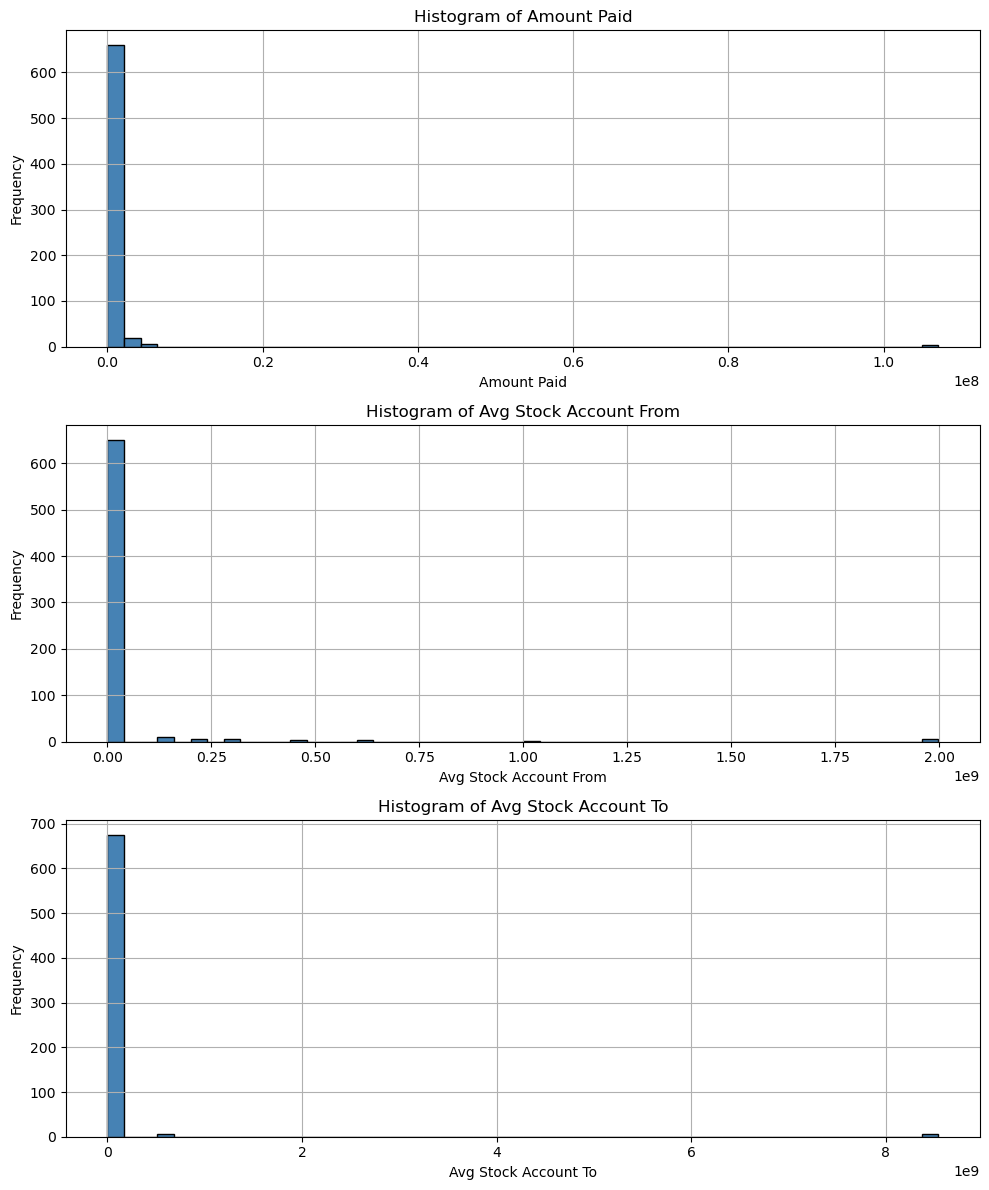

In [5]:
import matplotlib.pyplot as plt

cols = ['Amount Paid', 'Avg Stock Account From', 'Avg Stock Account To']

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

for i, col in enumerate(cols):
    axs[i].hist(d_fraud[col].dropna(), bins=50, color='steelblue', edgecolor='black')
    axs[i].set_title(f'Histogram of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


In [6]:
n_samples = 10000
np.random.seed(42)

records = []
user_id = 1

while len(records) < n_samples:
    transactions = int(max(1, round(np.random.normal(loc=N_transaction_D["mean"], scale=N_transaction_D["sd"]))))
    for _ in range(transactions):
        if len(records) >= n_samples:
            break
    # Generazione del record
        record = [
        1,  # Is Laundering
        f"SU{user_id}",  # From Account
        f"SU{user_id+1}",  # To Account
        np.random.choice(list(payment_type_D.keys()), p=list(payment_type_D.values())),
        np.random.lognormal(mean=ammount_paied_D["mu"], sigma=ammount_paied_D["sigma"]),
        np.random.choice(list(type_from_D.keys()), p=list(type_from_D.values())),
        np.random.choice(list(type_to_D.keys()), p=list(type_to_D.values())),
        np.random.lognormal(mean=Avg_Stock_From_D["mu"], sigma=Avg_Stock_From_D["sigma"]),
        np.random.lognormal(mean=Avg_Stock_To_D["mu"], sigma=Avg_Stock_To_D["sigma"]),
            ]
        records.append(record)
    user_id += 1

# Costruisci il DataFrame una sola volta
columns = ['Is Laundering', 'From Account', 'To Account', 'Payment Type',
           'Amount Paid', 'Type Account From', 'Type Account To',
           'Avg Stock Account From', 'Avg Stock Account To']

sinth_df = pd.DataFrame(records, columns=columns)


sinth_df

,Is Laundering,From Account,To Account,Payment Type,Amount Paid,Type Account From,Type Account To,Avg Stock Account From,Avg Stock Account To
0,1,SU1,SU2,Cheque,7.350442e+04,A,B,1.031965e+07,6.772959e+07
1,1,SU1,SU2,Cheque,3.662049e+04,B,B,1.692170e+07,1.319070e+07
2,1,SU1,SU2,ACH,1.756635e+03,B,E,2.737526e+06,1.622705e+06
3,1,SU1,SU2,ACH,2.145991e+06,B,E,4.001445e+06,2.473482e+06
4,1,SU1,SU2,Cash,1.241559e+05,B,B,1.981534e+06,5.921975e+07
...,...,...,...,...,...,...,...,...,...
9995,1,SU2080,SU2081,ACH,5.311715e+04,C,B,6.379185e+07,5.091610e+08
9996,1,SU2081,SU2082,ACH,1.130790e+06,D,B,2.418684e+06,1.684288e+08
9997,1,SU2081,SU2082,ACH,1.839120e+05,B,A,1.243811e+08,5.198905e+06
9998,1,SU2081,SU2082,ACH,2.158738e+06,B,E,1.138469e+07,4.434805e+07


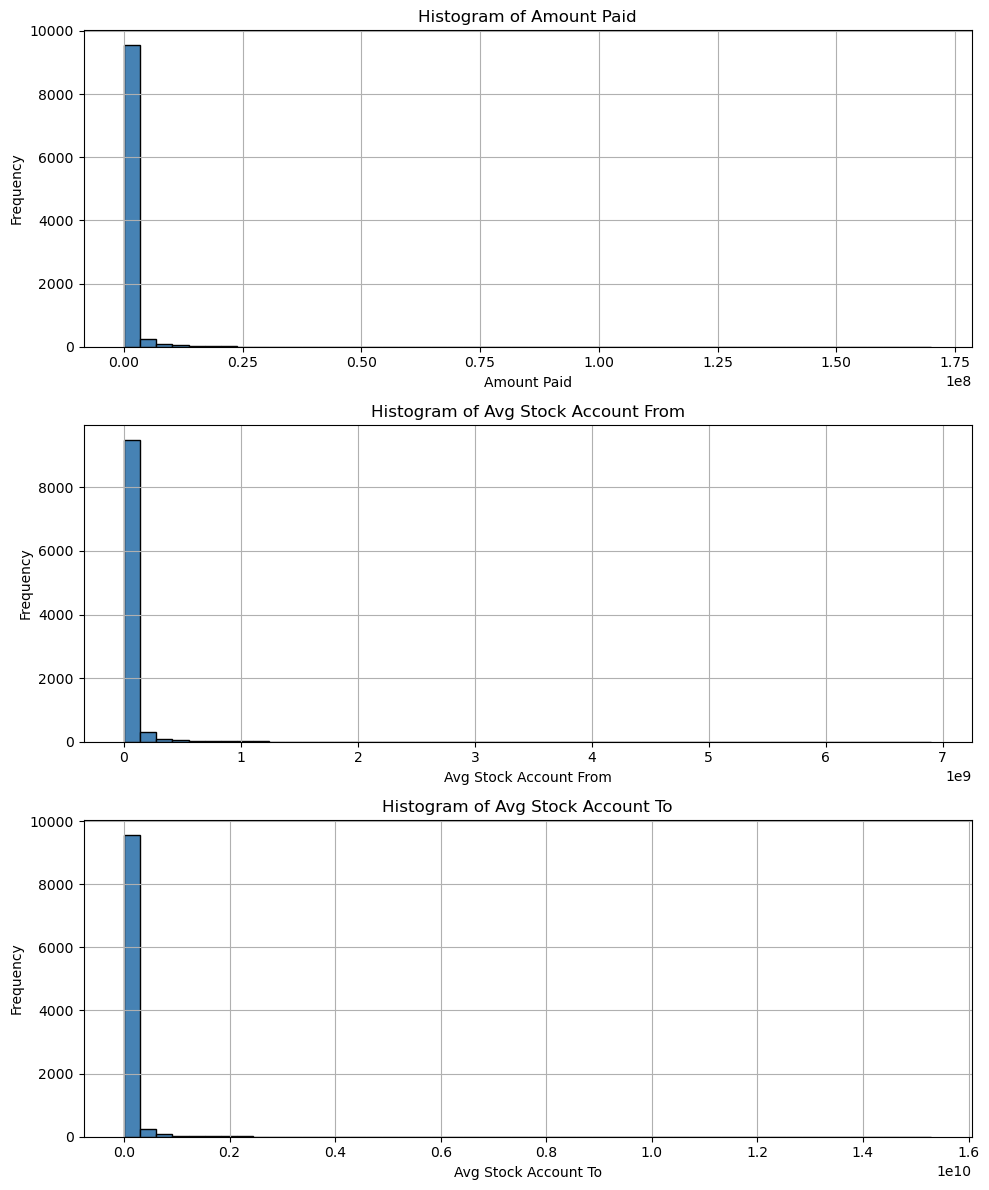

In [7]:
import matplotlib.pyplot as plt

cols = ['Amount Paid', 'Avg Stock Account From', 'Avg Stock Account To']

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

for i, col in enumerate(cols):
    axs[i].hist(sinth_df[col].dropna(), bins=50, color='steelblue', edgecolor='black')
    axs[i].set_title(f'Histogram of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


In [8]:
modded_df = pd.concat([d_train, sinth_df], ignore_index=True)

# Group by 'From Account' and 'To Account' to count transactions
transaction_counts = modded_df.groupby(['From Account', 'To Account']).size().reset_index(name='transaction_count')

# Merge the transaction counts back into the original dataframe
modded_df = modded_df.merge(transaction_counts, on=['From Account', 'To Account'], how='left')


In [9]:
# Colonne categoriali da codificare tramite indexing
categorical_cols = [
    'From Account',
    'To Account',
    'Payment Type',
    'Type Account From',
    'Type Account To'
]

# Copia del dataframe originale per evitare modifiche dirette
encoded_df = modded_df.copy()

# Encoding tramite factorize (integer indexing)
for col in categorical_cols:
    encoded_df[col], _ = pd.factorize(encoded_df[col])

# Conversione esplicita di tutte le colonne a numerico (float o int)
# Questo permette di convertire eventuali colonne che rimangono object (stringhe)
encoded_df = encoded_df.apply(pd.to_numeric, errors='coerce')

# In caso di valori NaN dopo coercion, si possono gestire con fillna (opzionale)
# Esempio: encoded_df = encoded_df.fillna(0)
cols_to_softmax = ["Amount Paid", "Avg Stock Account From", "Avg Stock Account To"]

for col in cols_to_softmax:
    x = encoded_df[col].values
    e_x = np.exp(x - np.max(x))  # Sottrai max per stabilità numerica
    encoded_df[col] = e_x / e_x.sum()
# Controllo finale tipi di dato
print(encoded_df.dtypes)
# 

Is Laundering               int64
From Account                int64
To Account                  int64
Payment Type                int64
Amount Paid               float64
Type Account From           int64
Type Account To             int64
Avg Stock Account From    float64
Avg Stock Account To      float64
transaction_count           int64
dtype: object


In [10]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
)

# --- Data prep ---
X = encoded_df.drop(columns=['Is Laundering'])
y = encoded_df['Is Laundering']

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'eta': 0.05,
    'max_depth': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 4
}

# Split dati per train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

from itertools import product

# Definisci i valori da testare per ogni iperparametro
eta_values = [0.01, 0.05, 0.1, 0.2, 0.3]
max_depth_values = [2, 3, 4]
subsample_values = [0.7, 0.8, 1.0]
gamma_values = [.1, .5, 1, 3, 5]

best_score = float('inf')  # Poiché stai monitorando 'error', valore più basso è meglio
best_params = None
best_num_boost_round = 0

for eta, max_depth, subsample, gamma in product(eta_values, max_depth_values, subsample_values, gamma_values):
    params['eta'] = eta
    params['max_depth'] = max_depth
    params['subsample'] = subsample
    params["gamma"] = gamma
    
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        early_stopping_rounds=20,
        metrics='error',
        seed=42,
        verbose_eval=False
    )

    mean_error = cv_results['test-error-mean'].min()
    best_round = cv_results['test-error-mean'].idxmin()


    if mean_error < best_score:
        best_score = mean_error
        best_params = params.copy()
        best_num_boost_round = best_round

print(f"\nBest params: {best_params}")
print(f"Best number of boosting rounds: {best_num_boost_round}")
print(f"Best error: {best_score:.5f}")

bst = xgb.train(best_params, dtrain, num_boost_round=best_num_boost_round)




Best params: {'objective': 'binary:logistic', 'eval_metric': 'error', 'eta': 0.3, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'gamma': 0.1}
Best number of boosting rounds: 37
Best error: 0.00004


In [11]:

def fraud_capture_rate(y_true, y_scores, top_n=485 ):
    df_eval = pd.DataFrame({'y_true': y_true, 'y_score': y_scores})
    df_sorted = df_eval.sort_values(by='y_score', ascending=False).head(top_n)
    frauds_in_top_n = df_sorted['y_true'].sum()
    total_frauds = df_eval['y_true'].sum()
    return frauds_in_top_n / total_frauds if total_frauds > 0 else 0



In [12]:

# --- Predictions ---
y_pred_proba = bst.predict(dval)
y_pred = [1 if p > 0.5 else 0 for p in y_pred_proba]

# --- Evaluation Metrics ---

# 1. AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_val, y_pred_proba)

# 2. Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_val, y_pred)


# 3. Fraud Capture Rate @ Top N (e.g. top 100 predictions)
fcr_top_100 = fraud_capture_rate(y_val.values, y_pred_proba, top_n=485)

# --- Output results ---
print(f"AUC: {auc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Fraud Capture Rate (Top 485): {fcr_top_100:.4%}")

print(f"Total score : {(auc + balanced_acc + fcr_top_100)/3:.3%}")


AUC: 0.9999
Balanced Accuracy: 0.9998
Fraud Capture Rate (Top 485): 14.7821%
Total score : 71.586%


In [13]:
d_test

# Group by 'From Account' and 'To Account' to count transactions
transaction_counts = d_test.groupby(['From Account', 'To Account']).size().reset_index(name='transaction_count')

# Merge the transaction counts back into the original dataframe
d_test = d_test.merge(transaction_counts, on=['From Account', 'To Account'], how='left')
# Colonne categoriali da codificare tramite indexing
categorical_cols = [
    'From Account',
    'To Account',
    'Payment Type',
    'Type Account From',
    'Type Account To'
]

# Copia del dataframe originale per evitare modifiche dirette
encoded_df = d_test.copy()

# Encoding tramite factorize (integer indexing)
for col in categorical_cols:
    encoded_df[col], _ = pd.factorize(encoded_df[col])

# Conversione esplicita di tutte le colonne a numerico (float o int)
# Questo permette di convertire eventuali colonne che rimangono object (stringhe)
encoded_df = encoded_df.apply(pd.to_numeric, errors='coerce')

# In caso di valori NaN dopo coercion, si possono gestire con fillna (opzionale)
# Esempio: encoded_df = encoded_df.fillna(0)

# Controllo finale tipi di dato
print(encoded_df.dtypes)

cols_to_softmax = ["Amount Paid", "Avg Stock Account From", "Avg Stock Account To"]

for col in cols_to_softmax:
    x = encoded_df[col].values
    e_x = np.exp(x - np.max(x))  # Sottrai max per stabilità numerica
    encoded_df[col] = e_x / e_x.sum()

dtest_dmatrix = xgb.DMatrix(data=encoded_df)

From Account                int64
To Account                  int64
Payment Type                int64
Amount Paid               float64
Type Account From           int64
Type Account To             int64
Avg Stock Account From    float64
Avg Stock Account To      float64
transaction_count           int64
dtype: object


In [14]:

# --- Predictions ---
y_pred_proba = bst.predict(dtest_dmatrix)
y_pred = [1 if p > 0.5 else 0 for p in y_pred_proba]


result = pd.DataFrame({"x" : y_pred_proba, "y" : y_pred})

result.to_csv("submission.txt", header = False, sep= " ", index= False)